# Understanding nighttime methane signals at the Amazon Tall Tower Observatory (ATTO)

### Santiago Botía B et al
#### Calculations and analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import seaborn as sns
import scipy
import matplotlib as mpl
%matplotlib inline

In [2]:
# Remember to always import this dataframe. I dont need the one merged with micromet and soil data
d_clean_mod = pd.read_pickle('./Data/ATTO_GHG_201203_201811_CO2avg')
ch4_30min   = d_clean_mod.iloc[:,10:15]
ch4_30min   = ch4_30min.assign(LTRound=ch4_30min.index.round('30min'))
ch4_30min.set_index('LTRound',inplace=True)
ch4_30min.head()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4
LTRound,,,,,
2012-03-06 20:30:00,1839.65,1840.56,1841.10,1841.07,1841.22
2012-03-06 21:00:00,1839.05,1839.98,1840.43,1841.53,1842.18
2012-03-06 21:30:00,1839.52,1841.29,1840.31,1841.67,1842.13
2012-03-06 22:00:00,1841.13,1841.85,1840.89,1842.17,1843.04
2012-03-06 22:30:00,1841.74,1842.83,1841.99,1842.62,1843.40


## Section 3.1 Seasonal and diurnal patterns of CH4 gradients at ATTO
### Percentages related to Figure 4.
- Setting up data to get time percentages according to the threshold.
- Here I create the day and night dataframes used in Figures_Sect2.1-3.1.ipynb

In [3]:
# gradient
thresh    = 8
ch4_30min = ch4_30min.assign(grad = ch4_30min.CH4_79 - ch4_30min.CH4_4)
# dropping nan
print(ch4_30min.shape, 'with nan')
ch4_30min.dropna(inplace=True)
print(ch4_30min.shape, 'after dropping nan')
# setting threshold
ch4_30min = ch4_30min.assign(GradFlag = ch4_30min['grad']>thresh)
# Selecting hours from index and creating a column
ch4_30min = ch4_30min.assign(Hour = ch4_30min.index.hour)
#night columns from hours XXX This might not be necessary
idx       = (ch4_30min['Hour']<=5) | (ch4_30min['Hour']>=19)
ch4_30min = ch4_30min.assign(night_F = idx)
# highlighting the non threshold measurements
ch4_30min = ch4_30min.assign(range_8 = ch4_30min['grad'].between(-thresh,thresh,inclusive=True))
ch4_30min = ch4_30min.assign(low_than8 = ch4_30min['grad'] < -thresh)
#print('total data points',ch4_30min.shape)

(118079, 6) with nan
(79944, 6) after dropping nan


In [4]:
print('separating in range between -%d and %d, above %d and below -%d, we get:'%(thresh,thresh,thresh,thresh))
print(ch4_30min['range_8'].sum(),ch4_30min['GradFlag'].sum(),ch4_30min['low_than8'].sum(),ch4_30min['range_8'].sum()+ch4_30min['GradFlag'].sum()+ch4_30min['low_than8'].sum())
print('last number is to confirm the total number of data points, should always be the same')

separating in range between -8 and 8, above 8 and below -8, we get:
63442 9461 7041 79944
last number is to confirm the total number of data points, should always be the same


In [5]:
print('Adding below and above -8 and 8 we get the following. Remember I havent separated between day and night')
ch4_30min['GradFlag'].sum()+ch4_30min['low_than8'].sum()

Adding below and above -8 and 8 we get the following. Remember I havent separated between day and night


16502

In [6]:
# Separating nights and day
nights = ch4_30min.between_time('20:00','06:00')
days   = ch4_30min.between_time('06:00','18:00')

In [7]:
# Grouping each range per month and calculating the total nights measurements to get percentages
nights_upper = nights['GradFlag'].groupby([nights.index.year,nights.index.month]).sum()
nights_mid   = nights['range_8'].groupby([nights.index.year,nights.index.month]).sum()
nights_lower = nights['low_than8'].groupby([nights.index.year,nights.index.month]).sum()

nights_upper.index.rename(['Year','Month'],inplace=True)
nights_mid.index.rename(['Year','Month'],inplace=True)
nights_lower.index.rename(['Year','Month'],inplace=True)

total_nights = nights['GradFlag'].loc[nights['GradFlag']==True].groupby(nights[nights['GradFlag']==True].index.month).count() + nights['GradFlag'].loc[nights['GradFlag']==False].groupby(nights[nights['GradFlag']==False].index.month).count()

n_upp_month  = nights_upper.groupby(level=1).sum()/total_nights
n_mid_month  = nights_mid.groupby(level=1).sum()/total_nights
n_low_month  = nights_lower.groupby(level=1).sum()/total_nights
total_n      = n_low_month + n_mid_month + n_upp_month

In [8]:
# Grouping each range per month and calculating the total day measuremenst to get percentages
days_upper = days['GradFlag'].groupby([days.index.year,days.index.month]).sum()
days_mid   = days['range_8'].groupby([days.index.year,days.index.month]).sum()
days_lower = days['low_than8'].groupby([days.index.year,days.index.month]).sum()

days_upper.index.rename(['Year','Month'],inplace=True)
days_mid.index.rename(['Year','Month'],inplace=True)
days_lower.index.rename(['Year','Month'],inplace=True)

total_days = days['GradFlag'].loc[days['GradFlag']==True].groupby(days[days['GradFlag']==True].index.month).count() + days['GradFlag'].loc[days['GradFlag']==False].groupby(days[days['GradFlag']==False].index.month).count()

d_upp_month  = days_upper.groupby(level=1).sum()/total_days
d_mid_month  = days_mid.groupby(level=1).sum()/total_days
d_low_month  = days_lower.groupby(level=1).sum()/total_days
total_d      = d_low_month + d_mid_month + d_upp_month

In [9]:
# Merging ranges for night and day and creating a day and night dataframes that can be used to hue in seaborn.
df_n = pd.concat([n_low_month,n_mid_month,n_upp_month,total_n],axis=1)
df_n.reset_index(inplace=True)
df_n.columns = ['month','lower_than8','MidRange','UpperRange','total']

df_d = pd.concat([d_low_month,d_mid_month,d_upp_month,total_d],axis=1)
df_d.reset_index(inplace=True)
df_d.columns = ['month','lower_than8','MidRange','UpperRange','total']

df_day_night = pd.concat([df_d,df_n],axis=0)
df_day_night = df_day_night.assign(Time = ['day','day','day', 'day', 'day','day','day', 'day','day','day','day','day','night','night',
                                           'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night'])

In [11]:
# changing columns names for export
df_n.columns = ['Months','lower_than_minus8','Between_minus8_plus8','greater_than8','total']
df_d.columns = ['Months','lower_than_minus8','Between_minus8_plus8','greater_than8','total']
#df_d.to_pickle('ATTO_Month_dayTime_timefrac')
#df_n.to_pickle('ATTO_Month_nightTime_timefrac')

In [12]:
print('Mean monthly gradient during nighttime when 8pbb threshold holds')
nights[nights['GradFlag'] == True].groupby(nights[nights['GradFlag'] == True].index.month).mean()['grad']

Mean monthly gradient during nighttime when 8pbb threshold holds


LTRound
1     15.263162
2     16.532406
3     20.289043
4     19.778522
5     21.393953
6     19.843176
7     23.541711
8     27.446447
9     32.273899
10    25.176571
11    17.333174
12    14.276000
Name: grad, dtype: float64

#### The following shows the mean minima for nighttime and daytime gradients, -236.2 and -455 for October. I refer to this value in section 3.1.

In [13]:
# Nights stats without applying threshold
nights['grad'].groupby(nights['grad'].index.month).describe()

,count,mean,std,min,25%,50%,75%,max
LTRound,,,,,,,,
1,2844.0,-0.086410,4.779475,-28.73,-2.2100,-0.690,0.9200,42.88
2,2701.0,-0.462621,5.132557,-19.77,-2.5600,-1.080,0.4800,45.93
3,3157.0,-0.923082,6.739486,-35.09,-3.7800,-1.910,-0.1500,63.16
4,3479.0,-0.930696,8.479537,-25.56,-4.6100,-2.180,0.4400,91.84
5,3510.0,1.606607,12.459258,-68.77,-4.7600,-1.260,5.1350,64.83
6,3514.0,1.231411,16.344859,-101.84,-5.3975,0.195,8.6425,81.25
7,3127.0,2.655491,23.123220,-227.46,-3.7350,1.760,10.7900,110.97
8,3608.0,9.709011,21.151607,-76.86,-1.6700,5.105,19.3750,166.86
9,2165.0,6.220536,23.661947,-95.85,-4.9300,0.520,11.6700,162.48


In [15]:
# Day stats without applying threshold
days['grad'].groupby(days['grad'].index.month).describe()

,count,mean,std,min,25%,50%,75%,max
LTRound,,,,,,,,
1,3312.0,-0.241969,2.698072,-25.06,-1.4900,-0.49,0.7100,31.97
2,3133.0,-0.481637,4.835348,-34.51,-2.1000,-0.88,0.2600,73.97
3,3684.0,-1.503404,3.736884,-35.02,-2.7200,-1.47,-0.4300,37.36
4,3937.0,-1.475019,7.505589,-168.76,-3.1700,-1.63,-0.4000,99.26
5,4073.0,-2.551589,14.008042,-455.32,-4.0100,-1.91,-0.0600,61.20
6,4067.0,-6.006838,20.255843,-162.98,-5.6300,-1.79,1.3100,59.65
7,3586.0,-5.571726,22.561902,-153.35,-6.2900,-0.67,3.0875,84.00
8,4227.0,-1.071173,17.767931,-197.36,-4.3000,0.19,3.6700,177.91
9,2594.0,-0.652695,23.956980,-312.07,-2.4075,-0.10,2.0075,161.48


#### Next I get the exact datetime at which these minima happened, for both day and nighttime only.

In [16]:
days['grad'].loc[days['grad']<-450]

LTRound
2014-05-29 16:00:00   -455.32
Name: grad, dtype: float64

In [17]:
nights['grad'].loc[nights['grad']<-235]

LTRound
2015-10-21 04:30:00   -236.2
Name: grad, dtype: float64

#### Next I show the complete stats for the entire gradient distribution, with no separation of daytime and no classification of threshold.

In [18]:
# ALL TIMES GRAD STATS
ch4_30min['grad'].describe()

count    79944.000000
mean        -0.074867
std         14.277683
min       -455.320000
25%         -3.050000
50%         -0.750000
75%          1.910000
max        194.620000
Name: grad, dtype: float64

#### Here, I select for classes

In [19]:
# Stats selecting the lower than -8 ppb class.
ch4_30min['grad'].loc[ch4_30min['low_than8']==True].describe()

count    7041.000000
mean      -23.929780
std        25.276147
min      -455.320000
25%       -26.350000
50%       -15.290000
75%       -10.470000
max        -8.010000
Name: grad, dtype: float64

In [20]:
# Stats selecting the above than 8 ppb class.
ch4_30min['grad'].loc[ch4_30min['GradFlag']==True].describe()

count    9461.000000
mean       22.138364
std        16.265006
min         8.010000
25%        11.410000
50%        16.740000
75%        27.270000
max       194.620000
Name: grad, dtype: float64

#### Looking at the hour in both day and night, for which the maximum happened

In [21]:
# hour maximum for nighttime
nights[nights['GradFlag'] == True].groupby('Hour').max()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4,grad,GradFlag,night_F,range_8,low_than8
Hour,,,,,,,,,,
0,2047.00,2028.99,2021.42,2020.37,2000.97,84.87,True,True,False,False
1,2031.26,2022.32,2012.83,2010.63,2002.82,75.53,True,True,False,False
2,2038.76,2041.80,2027.88,2026.97,2027.84,109.02,True,True,False,False
3,2044.22,2053.34,2063.07,2056.95,1999.94,194.62,True,True,False,False
4,2052.39,2045.50,2054.56,2045.90,2008.45,132.43,True,True,False,False
5,2064.87,2036.74,2022.30,2006.63,1992.96,162.48,True,True,False,False
6,2070.28,2014.79,2002.04,2003.67,1998.86,166.86,True,False,False,False
20,2022.88,2002.34,1984.09,1978.46,1968.50,74.61,True,True,False,False
21,2040.14,2026.78,2019.41,2010.95,1988.48,95.34,True,True,False,False


In [22]:
# hour maximum for daytime
days[days['GradFlag'] == True].groupby('Hour').max()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4,grad,GradFlag,night_F,range_8,low_than8
Hour,,,,,,,,,,
6,2072.38,2026.23,2002.04,2003.67,1998.86,177.91,True,False,False,False
7,2071.62,2021.42,2014.86,2010.34,1986.95,165.24,True,False,False,False
8,2121.49,2098.22,2105.17,2100.60,2025.49,157.93,True,False,False,False
9,2128.06,2126.81,2127.79,2124.99,2095.74,99.26,True,False,False,False
10,2008.12,2009.45,2010.22,2010.14,1995.36,37.17,True,False,False,False
11,2003.25,2002.76,1999.82,2002.17,1986.97,24.28,True,False,False,False
12,1928.43,1928.36,1928.72,1927.46,1911.35,19.82,True,False,False,False
13,1971.35,1973.52,1975.88,1963.77,1955.43,30.89,True,False,False,False
14,2002.92,2002.42,2001.24,2001.92,1985.77,24.70,True,False,False,False


## Section 3.2.2 Net radiation, sensible heat flux, friction velocity and thermal stratification for CH4 positive gradients 2013-2018

#### Alternative plots and further calculations.

In [23]:
df_full = pd.read_pickle('./Data/ATTO_GHG_Inst_flux_soil_30min')

In [24]:
#df_full = df_full.assign(grad_quant = pd.qcut(df_full.grad,q=[0,.09,.883,1],labels=['Lower','range','larger'],retbins=False))
df_full = df_full.assign(grad_quant = pd.qcut(df_full.grad,q=[0,.09,.883,1],retbins=False))

def mid(interval):
    return interval.mid

df_full = df_full.assign(grad_quant_mid = df_full['grad_quant'].apply(mid))
df_full['grad_quant_mid'] = df_full['grad_quant_mid'].astype(np.float64)

In [25]:
# Calculating Ribulk.
meanTht = df_full[['theta', 'theta73', 'theta55','theta40']].mean().mean()
deltaZ  = 79-40
Ritop   = (9.8/(meanTht)) * deltaZ * ((df_full.theta-df_full.theta40) / (df_full['Mean_Windsp[m/s]'] - df_full.WSp_42m)**2)
df_full = df_full.assign(Ritop = Ritop)

In [26]:
df_full_n = df_full.between_time('20:00','06:00')
df_full_n.columns[0:100];

### Alternative for Figure 9.
- This plot was not included because we wanted to show the nocturnal evolution.

NetRad Ks_2sampResult(statistic=0.17896850025450706, pvalue=3.1690728619103277e-149)
U* Ks_2sampResult(statistic=0.0990730222369543, pvalue=1.6091352662578409e-46)
Theta Ks_2sampResult(statistic=0.1968117250734212, pvalue=6.0684634161083e-162)
H Ks_2sampResult(statistic=0.06363121987467013, pvalue=6.289829674138968e-19)


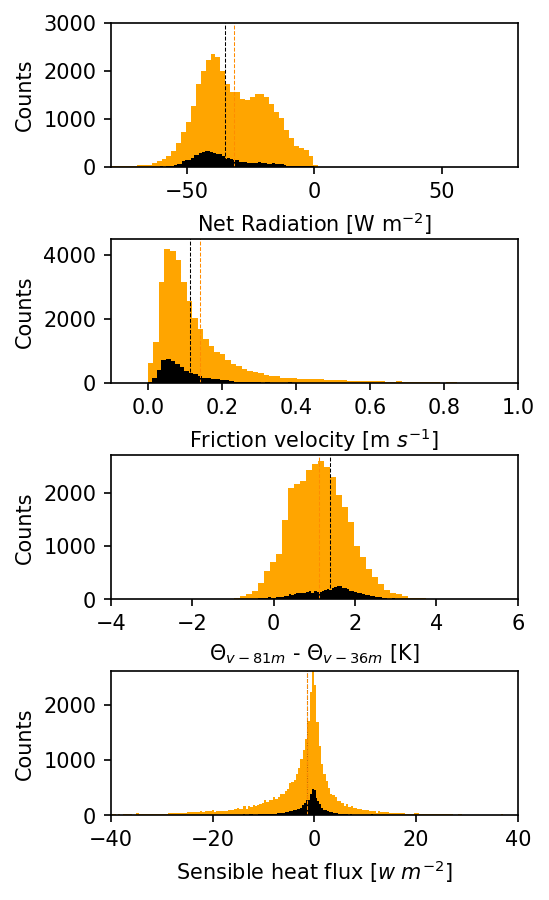

In [27]:
fig  = plt.figure(figsize=(3.5,7),dpi=150)
grid = plt.GridSpec(4,1,wspace=0.2,hspace=0.5)

row1 = fig.add_subplot(grid[0,0])
data = df_full_n[['Hour','GradFlag','NetRad']]
sns.distplot(data['NetRad'].loc[data['GradFlag']==False].dropna(),bins=500,ax=row1,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['NetRad'].loc[data['GradFlag']==True].dropna(),bins=500,ax=row1,hist=True,kde=False,
             hist_kws={"alpha": 1, "color": "k"})
row1.vlines(data['NetRad'].loc[data['GradFlag']==True].dropna().mean(),0,3000,linestyles='--',linewidth=0.5,colors='k')
row1.vlines(data['NetRad'].loc[data['GradFlag']==False].dropna().mean(),0,3000,linestyles='--',linewidth=0.5,color='darkorange')
row1.set_xlim(-80,80)
row1.set_ylim(0,3000)
row1.set_ylabel('Counts')
row1.set_xlabel('Net Radiation [W m$^{-2}$]')
print('NetRad',scipy.stats.ks_2samp(data['NetRad'].loc[data['GradFlag']==False].dropna().values,
                           data['NetRad'].loc[data['GradFlag']==True].dropna().values))

row2 = fig.add_subplot(grid[1,0])
data = df_full_n[['Hour','GradFlag','U-star[m/s]']]
sns.distplot(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna(),bins=100,ax=row2,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['U-star[m/s]'].loc[data['GradFlag']==True].dropna(),bins=100,ax=row2,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row2.vlines(data['U-star[m/s]'].loc[data['GradFlag']==True].dropna().mean(),0,5000,linestyles='--',linewidth=0.5,color='k')
row2.vlines(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna().mean(),0,5000,linestyles='--',linewidth=0.5,colors='darkorange')
row2.set_xlim(-0.1,1)
row2.set_ylim(0,4500)
row2.set_ylabel('Counts')
row2.set_xlabel('Friction velocity [m $s^{-1}$]')
print('U*',scipy.stats.ks_2samp(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna().values,
                           data['U-star[m/s]'].loc[data['GradFlag']==True].dropna().values))

row3 = fig.add_subplot(grid[2,0])
data = df_full_n[['Hour','GradFlag','PotVirt_81m','PotVirt_36m']]
data = data.assign(PotGradAbove = data['PotVirt_81m'] - data['PotVirt_36m'])
sns.distplot(data['PotGradAbove'].loc[data['GradFlag']==False].dropna(),bins=100,ax=row3,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['PotGradAbove'].loc[data['GradFlag']==True].dropna(),bins=100,ax=row3,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row3.vlines(data['PotGradAbove'].loc[data['GradFlag']==True].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='k')
row3.vlines(data['PotGradAbove'].loc[data['GradFlag']==False].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='darkorange')
row3.set_xlim(-4,6)
row3.set_ylim(0,2700)
row3.set_ylabel('Counts')
row3.set_xlabel('$\Theta_{v-81m}$ - $\Theta_{v-36m}$ [K]')
print('Theta',scipy.stats.ks_2samp(data['PotGradAbove'].loc[data['GradFlag']==False].dropna().values,
                           data['PotGradAbove'].loc[data['GradFlag']==True].dropna().values))


row4 = fig.add_subplot(grid[3,0])
data = df_full_n[['Hour','GradFlag','FluxTsonic[Watt/m2]']]
sns.distplot(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna(),bins=1000,ax=row4,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna(),bins=1000,ax=row4,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row4.vlines(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='k')
row4.vlines(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='darkorange')
row4.set_xlim(-40,40)
row4.set_ylim(0,2600)
row4.set_ylabel('Counts')
row4.set_xlabel('Sensible heat flux [$w$ $m^{-2}$]')
print('H',scipy.stats.ks_2samp(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna().values,
                           data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna().values))
plt.show()

### Analysis of Stability above canopy using Bulk Richardson Number
- Analysis not included in paper
- I think the 1/L analysis is more reliable at 1 min resolution

In [28]:
data     = df_full_n[['Hour','grad','GradFlag','PotVirt_81m','PotVirt_36m','grad_quant_mid','Ritop','FluxTsonic[Watt/m2]','Mean_Windsp[m/s]']]
data     = data.assign(PotGradAbove = data['PotVirt_81m'] - data['PotVirt_36m'])
data     = data.assign(Ritop_range = data['Ritop'].between(-5, 5, inclusive=True))
data     = data.assign(Ritop_int = pd.qcut(data[data['Ritop_range']==True]['Ritop'],q=10))
data     = data.assign(Ritop_int_mid = data['Ritop_int'].apply(mid))
data     = data.assign(StabilityFlag = np.where(data['Ritop']>0.25, 'Stable', 'Weakly stable'))
# sns.scatterplot(x='Ritop',y='grad',data=data[data['Ritop_range']==True])
# sns.boxplot(x='Ritop_int_mid',y='grad',data=data[data['Ritop_range']==True],fliersize=0)
# plt.ylim(-20,40)
# plt.show()

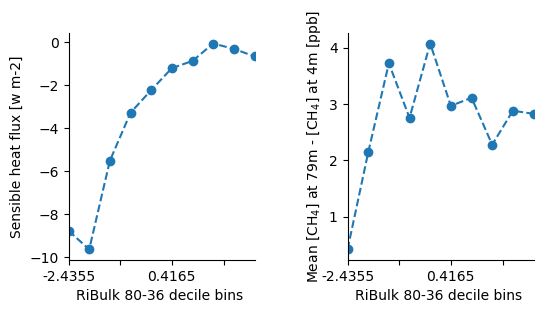

In [29]:
fig  = plt.figure(figsize=(6,3),dpi=100)
grid = plt.GridSpec(1,2,wspace=0.5,hspace=0.1)

## Top panel
ax1     = fig.add_subplot(grid[0, 0])
data_tp = data[data['Ritop_range']==True].groupby('Ritop_int_mid').mean()['FluxTsonic[Watt/m2]']
labels  = ['%0.2f'%(i) for i in data_tp.index.categories]
data_tp.plot(marker='o',linestyle='--',ax=ax1)
ax1.set_ylabel('Sensible heat flux [w m-2]')
ax1.set_xlabel('RiBulk 80-36 decile bins ')
#ax1.set_xticks(data_tp.index.categories)
#ax1.set_xlim(-50,60)
#ax1.set_xticklabels([' ','-48.76', '0.25', '0.40', '0.75', '4.17'])
#sns.despine()

## Row 2 panel
ax2    = fig.add_subplot(grid[0,1])
data[data['Ritop_range']==True].groupby('Ritop_int_mid').mean()['grad'].plot(marker='o',linestyle='--',ax=ax2)
#print(data[data['Ritop_range']==True].groupby('Ritop_int_mid').mean()['grad'])
#ax2.set_xticklabels([' ','-48.76', '0.25', '0.40', '0.75', '4.17'])
ax2.set_xlabel('RiBulk 80-36 decile bins ')
ax2.set_ylabel('Mean [CH$_4$] at 79m - [CH$_4$] at 4m [ppb]')
sns.despine()
plt.show()
# I need to add the x ticklabels

In [30]:
# Counting the amount of events at 30min, in which they happened under stable or weakly stable conditions
# This was not addded to paper
data[data['GradFlag']==True].groupby('StabilityFlag').count()['GradFlag']

StabilityFlag
Stable           1976
Weakly stable    4836
Name: GradFlag, dtype: int64

In [31]:
data[data['Ritop_range']==True].groupby('Ritop_int').mean()

,Hour,grad,PotVirt_81m,PotVirt_36m,grad_quant_mid,Ritop,FluxTsonic[Watt/m2],Mean_Windsp[m/s],PotGradAbove,Ritop_range
Ritop_int,,,,,,,,,,
"(-4.9910000000000005, 0.12]",9.697406,0.416971,301.235095,300.924001,3.076003,-0.130844,-8.769045,3.768806,0.265202,True
"(0.12, 0.188]",11.042538,2.140128,303.005572,302.123318,4.746747,0.156916,-9.639960,4.288728,0.871590,True
"(0.188, 0.245]",11.720260,3.725427,303.197001,302.059308,8.850194,0.217627,-5.516620,4.146142,1.137692,True
"(0.245, 0.298]",10.830570,2.754381,303.247661,301.952751,3.766133,0.270789,-3.281735,3.962898,1.293825,True
"(0.298, 0.368]",10.346071,4.076457,303.101014,301.762208,7.055132,0.331358,-2.227471,3.668509,1.337781,True
"(0.368, 0.465]",9.518385,2.968307,303.010489,301.615480,1.504624,0.413473,-1.206538,3.362317,1.395008,True
"(0.465, 0.618]",9.453497,3.113016,302.947048,301.500140,-1.072482,0.537539,-0.870818,3.060607,1.448139,True
"(0.618, 0.911]",9.399423,2.278585,302.903334,301.463376,0.055727,0.747968,-0.060593,2.693884,1.440876,True
"(0.911, 1.695]",9.208363,2.882145,302.816019,301.355974,2.100138,1.228963,-0.309170,2.274882,1.458404,True


## Section 3.2.3 Turbulence regimes
- It is important to recall that this analysis is done with 1 min data for 2014
- Alternative plots and further calculations.

In [32]:
df_full_1min = pd.read_pickle('./Data/df_GHG_uvw_1min_merged')
df_full_1min = df_full_1min.between_time('20:00','06:00',include_start=True,include_end=True)
df_full_1min.head();

In [33]:
# z over L functions. Transcribed from R by Santiago Botia, based on Michel Stefanello scripts.
##################################
def calc_1suL(T,wT,us):
    rc = get_rhocp(T)
    H0 = wT*rc
    #if wT.any() or rc.any() == np.nan:
    #    H0=np.nan
    #else:
    #    H0=wT*rc #Zannetti pag 59
    unosuL=hlm(rc,T,us,H0)
    return unosuL
def get_rhocp(Tm):
    rhocp = 1305*(273.16/Tm)
    #if Tm.any() < 0:
    #    rhocp = np.na
    #else:
    #    rhocp = 1305*(273.16/Tm)
    return rhocp
def hlm(rc,T,us,h0):
    hk = 0.4
    g  = 9.81
    hlm_2 = -(g*hk*h0)/(rc*T*us*us*us)
    #if T.isnull().any() or us.isnull().any() or T.any() < 0 or us.any() < 0:
    #    hlm_2=np.nan
    #else:
    #    hlm_2 = -(g*hk*h0)/(rc*T*us*us*us)
    return(hlm_2)  # output:1/L

## Stability Assessment for 1 min data, 2014 for dry and wet seasons
### Marht 1998 z/L ranges CASES 99
- (1) For the ‘weakly stable regime’ (0 < z/L < ε ≪ 1), the heat flux increases with increasing z/L due to increasing amplitude of the temperature fluctua- tions with increasing stability, where ε is the maximum stability for the weakly stable regime, equal to 0.06 for the 10 m data.
- (2) For the ‘transition stability regime’ (ε < z/L < O(1)), the heat flux decreases rapidly with increasing z/L due to decreasing amplitude of the vertical velocity fluctuations (Figure 1a) associated with stability constraints.
- (3) For the ‘very stable regime’ (z/L > O(1)), the heat flux is small but continues to decrease slowly with increasing stability.

### Bart Kruijt (2000) stability classes for Amazon forest study
- very unstable (1/Ltop < −0.1)
- moderately unstable (−0.1 < 1/Ltop < −0.01)
- neutral (−0.01 < 1/Ltop < 0.01)
- moderately stable (0.01 < 1/Ltop < 0.1) 
- very stable (1/Ltop > 0.1).

In [34]:
# calculating 1/L with one of the functions above
one_L        = calc_1suL(df_full_1min.mean_T+273.15,df_full_1min.wT,df_full_1min.Ustar)
df_full_1min = df_full_1min.assign(one_over_L = one_L) # *81 is z/L without, 1/L
df_full_1min = df_full_1min.assign(Z_over_L = (81.65-37.5)*one_L) # Z = measurementH - canopy height

In [35]:
# This is to confirm that for every Flag (True or False) use to mark the CH4 enhancements, 
# there is a corresponding number of 1/L or Z/L
# As the shape after and before removing nan are the same, we can continue.
print(df_full_1min.loc[:,['EnhanGrad','Z_over_L']].shape,df_full_1min.loc[:,['EnhanGrad','Z_over_L']].dropna().shape)
print(df_full_1min.loc[:,['EnhanGrad','one_over_L']].shape,df_full_1min.loc[:,['EnhanGrad','one_over_L']].dropna().shape)

(108621, 2) (108621, 2)
(108621, 2) (108621, 2)


count    108621.000000
mean          0.029103
std          25.911796
min       -8348.301372
25%          -0.030777
50%           0.034766
75%           0.152200
max         974.122821
Name: one_over_L, dtype: float64 count    108621.000000
mean          1.284911
std        1144.005815
min     -368577.505584
25%          -1.358798
50%           1.534905
75%           6.719608
max       43007.522546
Name: Z_over_L, dtype: float64


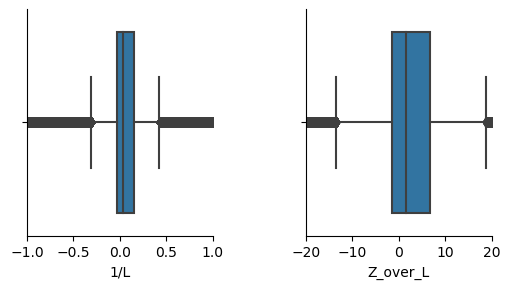

In [36]:
# Plotting distributions of 1/L and Z/L
fig  = plt.figure(figsize=(6,3),dpi=100)
grid = plt.GridSpec(1,2,wspace=0.5,hspace=0.1)

print(df_full_1min.one_over_L.describe(),df_full_1min.Z_over_L.describe())
## Top panel
ax1     = fig.add_subplot(grid[0, 0])
sns.boxplot(df_full_1min.one_over_L,ax=ax1)
ax1.set_xlabel('1/L')
ax1.set_xlim(-1,1)
sns.despine()

## Row 2 panel
ax2    = fig.add_subplot(grid[0,1])
sns.boxplot(df_full_1min.Z_over_L,ax=ax2)
ax2.set_xlim(-20,20)
sns.despine()
plt.show()

#### Here I am constraining the analysis for the data within the whiskers to avoid large outliers

In [37]:
# 1/L Kruijt, calculating the IQR based on the numbers above
IQR     = df_full_1min.one_over_L.describe()[6] - df_full_1min.one_over_L.describe()[4]
loval_k = df_full_1min.one_over_L.describe()[4] - 1.5 * IQR
hival_k = df_full_1min.one_over_L.describe()[6] + 1.5 * IQR
print(loval_k,hival_k)

-0.305241401873438 0.4266640546736604


In [38]:
# Marht, calculating the IQR based on the numbers above
IQR     = df_full_1min.Z_over_L.describe()[6] - df_full_1min.Z_over_L.describe()[4]
loval_m = df_full_1min.Z_over_L.describe()[4] - 1.5 * IQR
hival_m = df_full_1min.Z_over_L.describe()[6] + 1.5 * IQR
print(loval_m,hival_m)

-13.476407892712292 18.83721801384211


In [39]:
# Defining classes according to Marht's regimes
bins         = [loval_m,0,0.06,1,hival_m] 
df_full_1min = df_full_1min.assign(z_over_L_class_marht =  pd.cut(df_full_1min.Z_over_L,bins))

# Defining classes according to Kruijt's classes
bins    = [loval_k,-0.1,-0.01,0.01,0.1,hival_k] # limiting distribution 
# I used this one on the paper to avoid large outliers
# bins         = [df_full_1min.one_over_L.min(),-0.1,-0.01,0.01,0.1,df_full_1min.one_over_L.max()] # inlcuding all distribution
# using the above bins, assures that the percentages add up to 100
df_full_1min = df_full_1min.assign(one_over_L_class_kruijt =  pd.cut(df_full_1min.one_over_L,bins))

#### Number of enhanced CH$_4$ events in each stability class, according Marht and Kruijt

In [40]:
# Total enhancement events at 1 min. 
EnhanGradTotal = df_full_1min['EnhanGrad'].sum()
EnhanGradTotal

20647

In [41]:
# This is not included, but have it here in case a reviewer ask for it
df_marht = df_full_1min[['EnhanGrad','z_over_L_class_marht']].groupby('z_over_L_class_marht').sum()
df_marht = df_marht.assign(Percentages = df_marht['EnhanGrad']/EnhanGradTotal*100)
df_marht

,EnhanGrad,Percentages
z_over_L_class_marht,,
"(-13.476, 0.0]",5023.0,24.327990
"(0.0, 0.06]",118.0,0.571512
"(0.06, 1.0]",1637.0,7.928513
"(1.0, 18.837]",9215.0,44.631181


#### The following is the data used in Table 2. 

In [42]:
df_kruijt = df_full_1min[['EnhanGrad','one_over_L_class_kruijt']].groupby('one_over_L_class_kruijt').sum()
df_kruijt = df_kruijt.assign(Percentages = df_kruijt['EnhanGrad']/EnhanGradTotal*100)
print(df_kruijt['Percentages'].sum())
df_kruijt

77.45919504044171


,EnhanGrad,Percentages
one_over_L_class_kruijt,,
"(-0.305, -0.1]",1967.0,9.526808
"(-0.1, -0.01]",2483.0,12.025960
"(-0.01, 0.01]",1374.0,6.654720
"(0.01, 0.1]",5506.0,26.667312
"(0.1, 0.427]",4663.0,22.584395


#### Note that the percentages do not add up 100, because not all the distribution was considered.

### Alternative plots based on the 1 min data
- Same plots as in Fig 9. but with 1 min data
- Additional analysis based on wind direction and wind speed bins

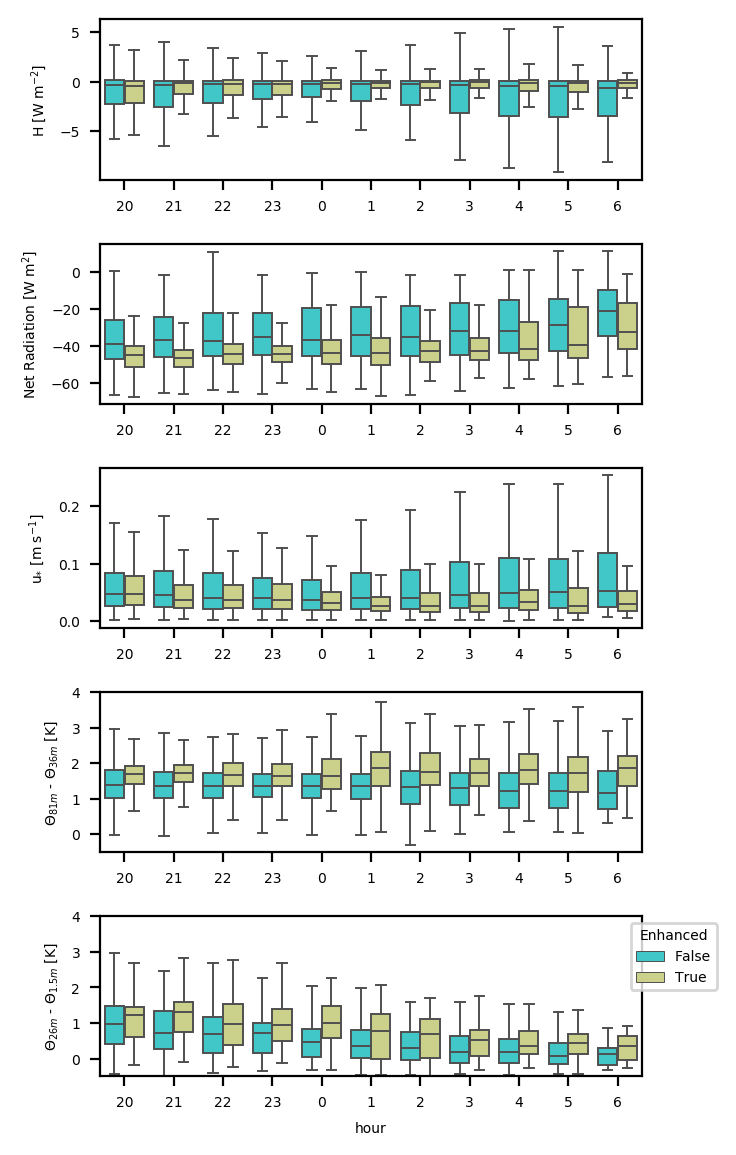

In [44]:
fig  = plt.figure(figsize=(3.5,7),dpi=200)
grid = plt.GridSpec(5,1,wspace=0.5,hspace=0.4)

ax1  = fig.add_subplot(grid[0, 0])
sns.boxplot(x=df_full_1min['hour'],y=df_full_1min['wT']*1004.67*1.2923,hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],
            data=df_full_1min,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
ax1.set_ylabel('H [W m$^{-2}$]')
ax1.set_xlabel(' ')
#ax1.set_xlabel('Nighttime Hours [Local Time]')
ax1.get_legend().remove()
#================================================================================================
ax2  = fig.add_subplot(grid[1, 0])
sns.boxplot(x='hour',y='Rnet',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax2,showmeans=False)
ax2.set_ylabel('Net Radiation [W m$^2$]')
ax2.set_xlabel(' ')
ax2.get_legend().remove()
#================================================================================================
ax3  = fig.add_subplot(grid[2, 0])
sns.boxplot(x='hour',y='Ustar',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax3)
ax3.set_ylabel('u$_{*}$ [m s$^{-1}$]')
ax3.set_xlabel(' ')
ax3.get_legend().remove()
#================================================================================================
ax4  = fig.add_subplot(grid[3, 0])
df_full_1min        = df_full_1min.assign(PotGradAbove = df_full_1min.theta - df_full_1min.theta36)
df_full_1min        = df_full_1min.assign(PotGradWithin = df_full_1min.theta26 - df_full_1min.theta1_5)
sns.boxplot(x='hour',y='PotGradAbove',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax4)
ax4.set_ylabel('$\Theta_{81m}$ - $\Theta_{36m}$ [K]')
ax4.set_ylim(-0.5,4)
ax4.set_xlabel(' ')
ax4.get_legend().remove()
#================================================================================================
ax5  = fig.add_subplot(grid[4, 0])
sns.boxplot(x='hour',y='PotGradWithin',hue='EnhanGrad',order=[20,21,22,23,0,1,2,3,4,5,6],data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax5)
ax5.set_ylim(-0.5,4)
ax5.set_ylabel('$\Theta_{26m}$ - $\Theta_{1.5m}$ [K]')
#================================================================================================
mpl.rcParams['font.size'] = 5
mpl.rcParams['lines.linewidth'] = 0.7
mpl.rcParams['figure.frameon'] = False

plt.legend(bbox_to_anchor=[1.15,1],title='Enhanced')
plt.show()

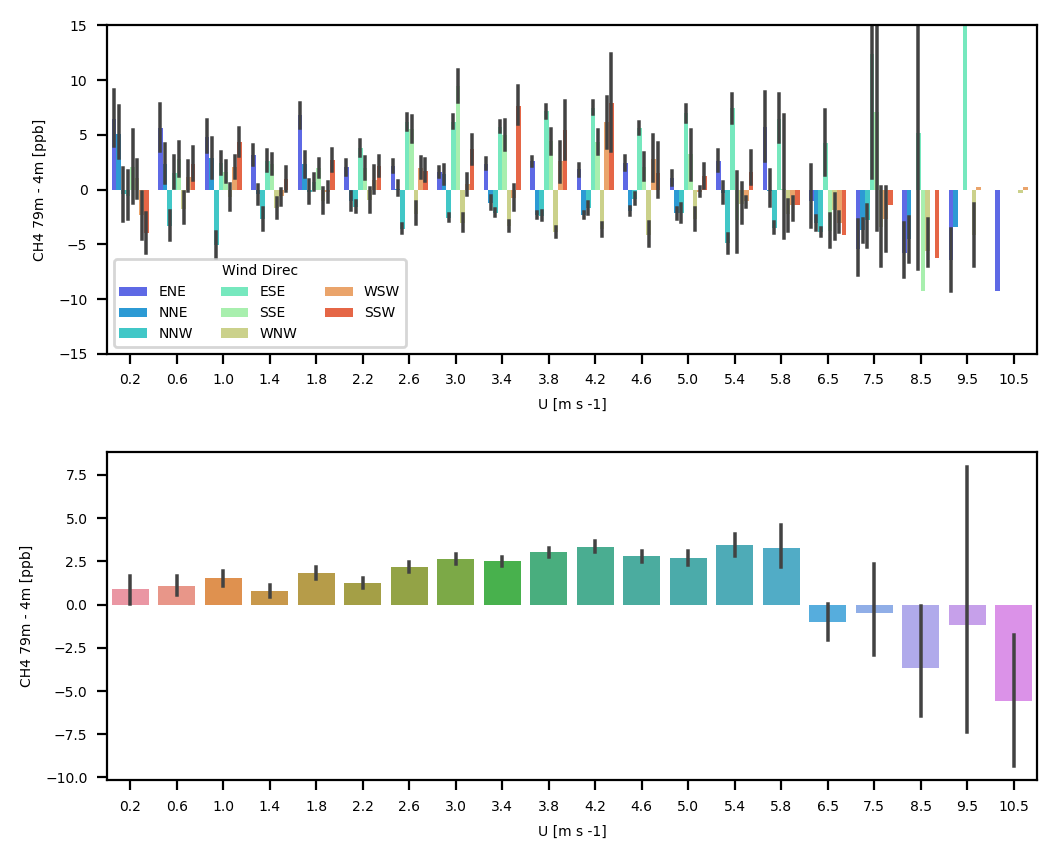

In [45]:
fig  = plt.figure(figsize=(6,5),dpi=200)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=8),showfliers=False,ax=ax1)
sns.barplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full_1min,
            palette=sns.color_palette(palette="rainbow",n_colors=8),ax=ax1)
labels     = ['%.1f'%(i) for i in sorted(list(set(df_full_1min['WindClassMid'].values)))]
ax1.set_xticklabels(labels)
ax1.set_ylabel('CH4 79m - 4m [ppb]')
ax1.legend(loc='lower left',title='Wind Direc',ncol=3)
ax1.set_xlabel('U [m s -1]')
ax1.set_xlim(-0.5,19.5)
ax1.set_ylim(-15,15)

ax2  = fig.add_subplot(grid[1, 0])
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),showfliers=False,ax=ax1)
#sns.boxplot(x='WindClassMid',y='CH4_grad',hue='cluster',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=8),showfliers=False,ax=ax1)
#sns.barplot(x='WindClassMid',y='CH4_grad',hue='EnhanGrad',data=df_full,palette=sns.color_palette(palette="rainbow",n_colors=2),ax=ax1)
sns.barplot(x='WindClassMid',y='CH4_grad',data=df_full_1min,ax=ax2)
labels     = ['%.1f'%(i) for i in sorted(list(set(df_full_1min['WindClassMid'].values)))]
#labels[-2] = '12.5'
#labels[-1] = '12.5'
labels.append('13.5')

ax2.set_ylabel('CH4 79m - 4m [ppb]')
ax2.set_xticklabels(labels)
ax2.set_xlabel('U [m s -1]')
ax2.set_xlim(-0.5,19.5)
#plt.ylim(-15,60)
plt.show()

## Wind Speed Analysis
- Here I look at the distribution of the wind speed to have an idea of what are the most probable distances
- This information is used in Section 3.3.1, 80% of the wind speed for nighttime positive gradients is below 4 m s-1

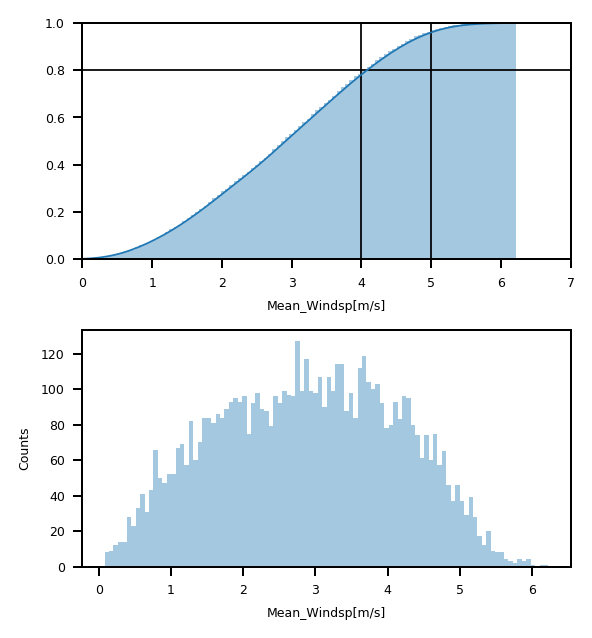

In [46]:
# Looking at the distribution of wind speed using the positive gradient flag
fig  = plt.figure(figsize=(3.5,4),dpi=180)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==True].dropna(), bins=100,
             hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),ax=ax1)

ax1.vlines(5,0,1)
ax1.vlines(4,0,1)
ax1.hlines(0.8,-2,15)
ax1.set_xlim(0,7)
ax1.set_ylim(0,1)

ax2  = fig.add_subplot(grid[1, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==True].dropna(),bins=100,ax=ax2,kde=False)
ax2.set_ylabel('Counts')
plt.show()

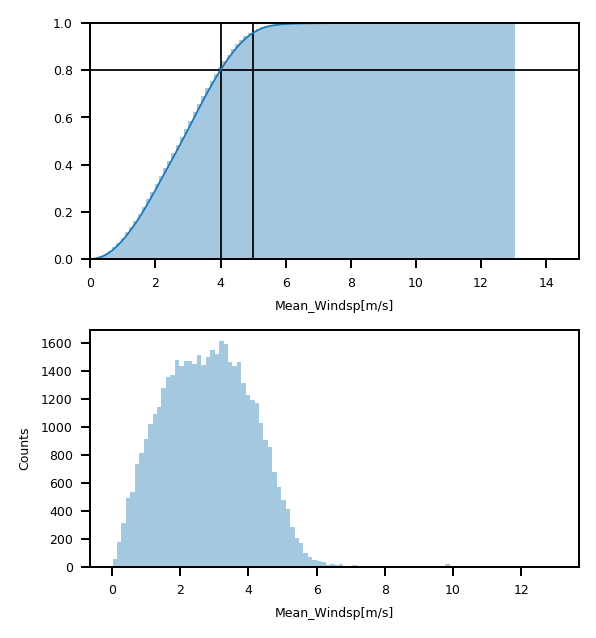

In [47]:
# All nighttime, no use of positive gradient flag
fig  = plt.figure(figsize=(3.5,4),dpi=180)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].dropna(),bins=100,
             hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True),ax=ax1)

ax1.vlines(5,0,1)
ax1.vlines(4,0,1)
ax1.hlines(0.8,-2,17)
ax1.set_xlim(0,15)
ax1.set_ylim(0,1)

ax2  = fig.add_subplot(grid[1, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].dropna(),ax=ax2,bins=100,kde=False)
ax2.set_ylabel('Counts')
plt.show()

### The following supports indirectly the rejection of the Amazon river as a source, because 
- Almost 71 % of events happen at wind speeds between 1-4 m s-1

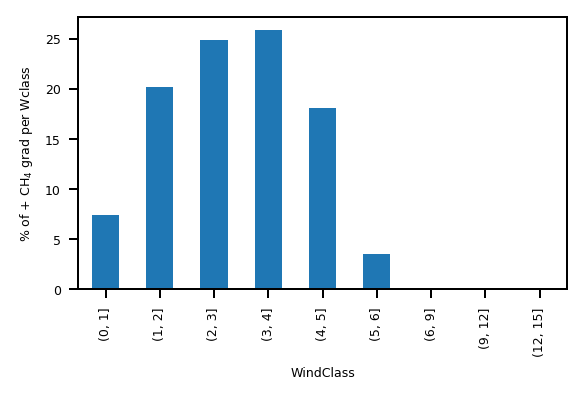

In [48]:
fig  = plt.figure(figsize=(3.5,2),dpi=180)
bins             = [np.arange(0,6,1),np.arange(6,18,3)]
bins             = np.concatenate(bins).ravel()
df_full_n        = df_full_n.assign(WindClass = pd.cut(df_full_n['Mean_Windsp[m/s]'],bins,right=True))
wind_c_group     = df_full_n[['WindClass','GradFlag']].dropna().groupby('WindClass').sum()
wind_c_group     = wind_c_group.assign(Per_event_Wclass = wind_c_group.GradFlag/wind_c_group.GradFlag.sum() * 100)
wind_c_group['Per_event_Wclass'].plot(kind='bar')
plt.ylabel('% of + CH$_4$ grad per Wclass')
plt.show()

In [47]:
20.2217 + 24.8456 + 25.8432

70.9105